You have previously built a 2-layer Neural Network (with a single hidden layer). In this lab, you will

* Implement some functions required to build a deep neural network, with as many layers as you want.
* In your implementation, different activation functions can be used in the hidden layers
* Apply your implemented models for classifying the Cat and Non-Cat dataset.
* Experience the vanishing gradient descent problem.


**After this lab you will be able to:**
- Gain a better understanding of different types of activation functions
- Use non-linear units like ReLU to improve your model
- Implement an easy-to-use neural network class
- Build a deeper neural network (with more than 1 hidden layer)


**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this lab. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- dnn_utils provides some necessary functions for this notebook.
- testCases provides some test cases to assess the correctness of your functions
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us reproduce your work. Please don't change the seed. 

In [179]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases_v2 import *
from dnn_utils_v2 import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## 2 - Outline of the lab

To build your deep neural network, you will be implementing more "helper functions". Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this lab, you will:

- Initialize the parameters for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
     - Stack the previous implemented [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives you a new L_model_forward function.
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.


<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center> <b>Figure 1</b></center></caption><br>


**Note** that for every forward function, there is a corresponding backward function. That is why at every step of your forward module you will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module you will then use the cache to calculate the gradients. This lab will show you exactly how to carry out each of these steps. 

## 3 - Initialization for your L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep`, you should make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| | **Shape of W** | **Shape of b** | **Activation** | **Shape of Activation** |
|-----------------|----------------|----------------|------------------|------------------------|
| **Layer 1**     | $(n^{[1]},12288)$ | $(n^{[1]},1)$ | $Z^{[1]} = W^{[1]}  X + b^{[1]}$ | $(n^{[1]},209)$ |
| **Layer 2**     | $(n^{[2]}, n^{[1]})$ | $(n^{[2]},1)$ | $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ | $(n^{[2]}, 209)$ |
| $\vdots$        | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| **Layer L-1**   | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$ |
| **Layer L**     | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$ | $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$ | $(n^{[L]}, 209table>


### Task 1: Implement initialization for an L-layer Neural Network.

**Instructions**:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use random initialization for the weight matrices. Use `np.random.rand(shape) /np.sqrt(layer_dims[l-1]`for layer l.
- Use zeros initialization for the biases. Use `np.zeros(shape)`.
- We will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, the `layer_dims` for the "Planar Data classification model" from last week would have been [2,4,1]: There were two inputs, one hidden layer with 4 hidden units, and an output layer with 1 output unit. Thus means `W1`'s shape was (4,2), `b1` was (4,1), `W2` was (1,4) and `b2` was (1,1). Now you will generalize this to $L$ layers! 
- Here is the implementation for $L=1$ (one layer neural network). It should inspire you to implement the general case (L-layer neural network).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) / np.sqrt(layer_dims[0])
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [180]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [181]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> <b>W1</b> </td>
    <td>[[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]</td> 
  </tr>
  
  <tr>
    <td><b>b1</b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td><b>W2</b> </td>
    <td>[[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]</td> 
  </tr>
  
  <tr>
    <td><b>b2</b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

## 4 - Forward propagation module
In deep learning, the "[LINEAR->ACTIVATION]" computation is counted as a single layer in the neural network, not two layers. 

### L-Layer Model 

For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : <i>[LINEAR -> RELU] x (L-1) -> LINEAR -> SIGMOID</i> model</center></caption><br>

### Task 2: Implement the forward propagation of the above model.

**Instruction**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

**Tips**:
- Use the functions you had previously written 
- Use a for loop to replicate [LINEAR->Activation] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [182]:
def L_model_forward(X, parameters, activation):
    """
    Implement forward propagation for the [LINEAR->activation]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> activation]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation=activation)
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = 'sigmoid')
    caches.append(cache)

    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [183]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters, activation='relu')
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2


<table style="width:40%">
  <tr>
    <td> <b>AL</b> </td>
    <td > [[ 0.17007265  0.2524272 ]]</td> 
  </tr>
  <tr>
    <td> <b>Length of caches list</b> </td>
    <td > 2</td> 
  </tr>
</table>

Great! Now you have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing your predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, you can compute the cost of your predictions.

## 5 - Backward propagation module

### 5.1 - Two-Layer Model Backward 

<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center> <b>Figure 3</b> : Forward and Backward propagation for <i>LINEAR->RELU->LINEAR->SIGMOID</i> <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</i>  </center></caption>

<!-- 
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

You have implemented this in your last lab

### 5.2 - L-Model Backward 

Now, similar to forward propagation, you are going to build the backward propagation in  this way:
- [LINEAR -> Activation] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

 Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center>  <b>Figure 5</b> : Backward pass  </center></caption>

**Initializing backpropagation**:
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

### Task 3: Implement backpropagation for the *[LINEAR->Activation] $\times$ (L-1) -> LINEAR -> SIGMOID* model. 

In [184]:
def L_model_backward(AL, Y, caches, activation):
    """
    Implement the backward propagation for the [LINEAR->activation] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "activation" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, caches[L-1], activation='sigmoid')
    
    for l in reversed(range(L-1)):
        # lth layer: (activation -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
       grads['dA' + str(l+1)] = linear_activation_backward(grads["dA" + str(l + 2)], caches[l], activation = activation)[0]
       grads['dW' + str(l+1)] = linear_activation_backward(grads["dA" + str(l + 2)], caches[l], activation = activation)[1]
       grads['db' + str(l+1)] = linear_activation_backward(grads["dA" + str(l + 2)], caches[l], activation = activation)[2]
       
       ### END CODE HERE ###

    return grads

In [185]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches, activation='relu')
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


**Expected Output**

<table style="width:60%">
  
  <tr>
    <td > dW1 </td> 
           <td > [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]] </td> 
  </tr> 
  
   <tr>
   <td > db1 </td> 
   <td > [[-0.22007063]
 [ 0.        ]
 [-0.02835349]] </td> 
  </tr> 
  
  <tr>
  <td > dA1 </td> 
           <td > [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]] </td> 

  </tr> 
</table>



## 6 - Parameters update module

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

### Task 4: Implement `update_parameters()` to update your parameters using gradient descent. 

**Instructions**:
Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 


In [186]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    ### END CODE HERE ###
        
    return parameters

In [187]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Expected Output**:

<table style="width:100%"> 
    <tr>
    <td > W1 </td> 
           <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td> 
  </tr> 
  
   <tr>
    <td > b1 </td> 
           <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </td> 
  </tr> 
  <tr>
    <td > W2 </td> 
           <td > [[-0.55569196  0.0354055   1.32964895]]</td> 
  </tr> 
  
   <tr>
    <td > b2 </td> 
           <td > [[-0.84610769]] </td> 
  </tr> 
</table>


## 7 - Merge all functions into a L_Layer model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together with the following structure:  [LINEAR -> RELU]x(L-1) -> LINEAR -> SIGMOID. The functions you may need and their inputs are:

```
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
    
```    

### Task 5: please fill in the blanks to Build your L-layer model

In [188]:
def L_layer_model(X, Y, layers_dims, activation, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->activation]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    activation -- the activation to be used in this model
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> activation]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, cache = L_model_forward(X, parameters, activation)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, cache, activation)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 8 - Training your model on the Cat and Non-Cat dataset

In [189]:
import h5py
import numpy as np

# Loading the data (cat/non-cat)
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
train_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

In [190]:
# Reshape the training and test examples 
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


### Task 6: Let's train the model as a 4-layer neural network on the dataset using the following setting

```
layers_dims = [12288, 20, 7, 5, 1] 
activation='relu'
num_iterations=2500 
print_cost=True

```

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


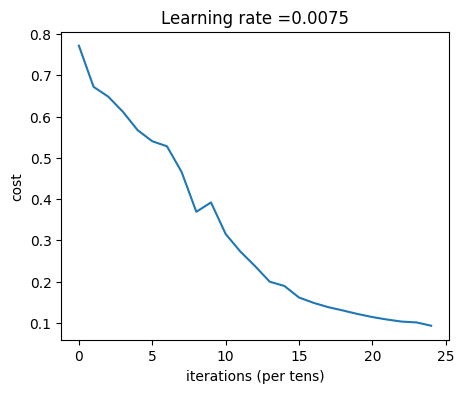

In [191]:
parameters = L_layer_model(train_x, train_y, layers_dims = [12288, 20, 7, 5, 1], activation='relu', num_iterations = 2500, print_cost = True)

## 9 - Making prediction

In [192]:
def predict(X, y, parameters, activation):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters, activation=activation)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

    plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'


## 10 - Performance Evaluation

### Task 7: Output the training accuracy and test accuracy below

In [193]:
predictions_train = predict(train_x, train_y, parameters, activation= 'relu')

Accuracy: 0.9856459330143539


In [194]:
predictions_test = predict(test_x, test_y, parameters, activation = 'relu')

Accuracy: 0.8


Congrats! It seems that your 4-layer neural network has better performance than your 2-layer neural network  on the same test set. 

This is good performance for this task. Nice job! 



##  11 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images.

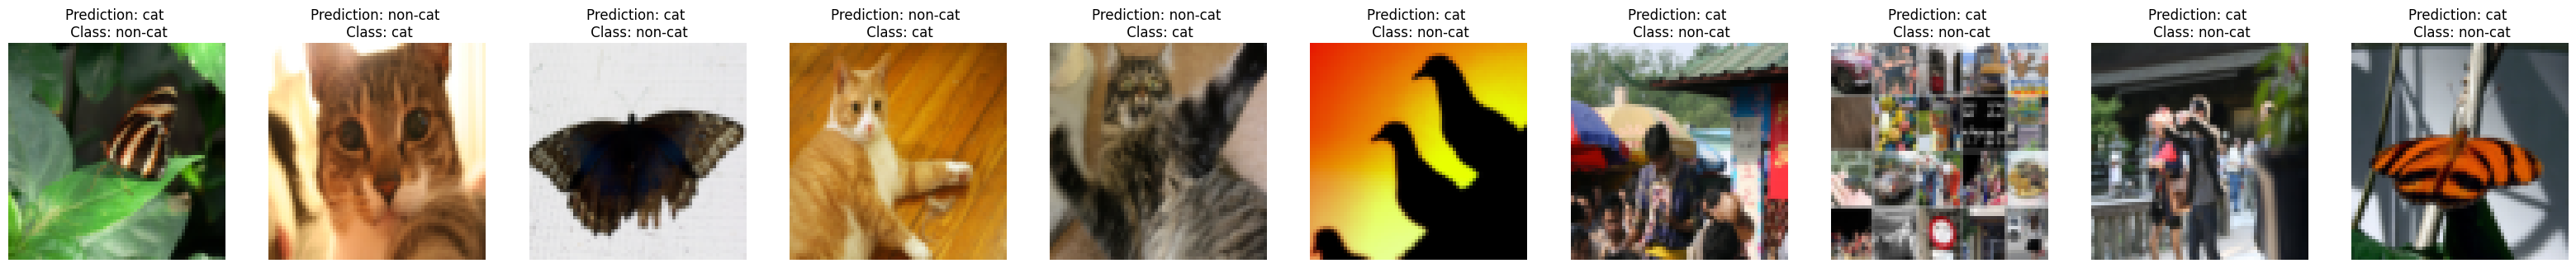

In [195]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)

**A few type of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### Task 8 - Using Different initialization Method

In the previous lab where you built your two-layer neural nets, you used:

- Use random initialization for the weight matrices. Use `np.random.rand(shape) * 0.01`.

Commenting out the current initialization statement and replace it with the above one, retrain this model
```
layers_dims = [12288, 20, 7, 5, 1] 
activation='relu'
num_iterations=2500 
print_cost=True

```
Please plot the learning curve, can you try to explain why the results are different

**Note**: you need to change back to the previous initialization for the following tasks

In [196]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

Cost after iteration 0: 0.693149
Cost after iteration 100: 0.678010
Cost after iteration 200: 0.667599
Cost after iteration 300: 0.660421
Cost after iteration 400: 0.655457
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649615
Cost after iteration 700: 0.647941
Cost after iteration 800: 0.646769
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644960
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


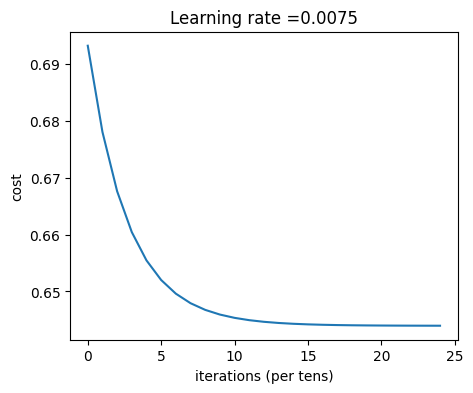

In [197]:
parameters = L_layer_model(train_x, train_y, layers_dims = [12288, 20, 7, 5, 1], activation='relu', num_iterations = 2500, print_cost = True)

In [198]:
predictions_train = predict(train_x, train_y, parameters, activation= 'relu')  
predictions_test = predict(test_x, test_y, parameters, activation = 'relu')

Accuracy: 0.6555023923444976
Accuracy: 0.3400000000000001


The learning curve converges much slower compared to the alterate form of initialization, likely due to improper scaling. Therefore, the learning curve is smoother but bounded to a much smaller range, which ultimately leads to the poorer performance in accuracy in both the test and training set.

### Task 9 - Using Sigmoid as Activation function for the hidden layer

In [199]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
#num_iterations=3500

In [200]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


Cost after iteration 0: 0.908534
Cost after iteration 100: 0.735150
Cost after iteration 200: 0.676330
Cost after iteration 300: 0.655724
Cost after iteration 400: 0.648416
Cost after iteration 500: 0.645775
Cost after iteration 600: 0.644790
Cost after iteration 700: 0.644400
Cost after iteration 800: 0.644225
Cost after iteration 900: 0.644127
Cost after iteration 1000: 0.644056
Cost after iteration 1100: 0.643992
Cost after iteration 1200: 0.643929
Cost after iteration 1300: 0.643863
Cost after iteration 1400: 0.643793
Cost after iteration 1500: 0.643718
Cost after iteration 1600: 0.643637
Cost after iteration 1700: 0.643551
Cost after iteration 1800: 0.643459
Cost after iteration 1900: 0.643359
Cost after iteration 2000: 0.643252
Cost after iteration 2100: 0.643137
Cost after iteration 2200: 0.643010
Cost after iteration 2300: 0.642873
Cost after iteration 2400: 0.642724
Cost after iteration 2500: 0.642563
Cost after iteration 2600: 0.642393
Cost after iteration 2700: 0.642214
Cost

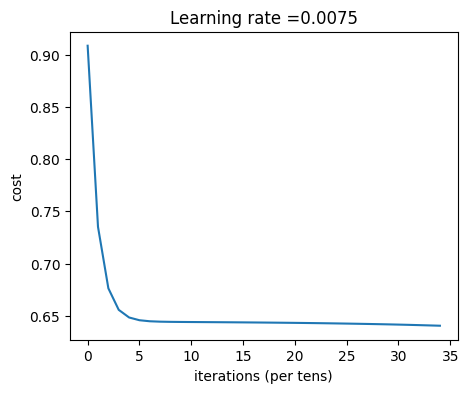

In [201]:
parameters = L_layer_model(train_x, train_y, layers_dims = [12288, 20, 7, 5, 1], activation='sigmoid', num_iterations = 3500, print_cost = True)

In [202]:
predictions_train = predict(train_x, train_y, parameters, activation= 'sigmoid')  
predictions_test = predict(test_x, test_y, parameters, activation = 'sigmoid')

Accuracy: 0.6555023923444976
Accuracy: 0.3400000000000001



### Task 10 - Using Softplus as Activation function for the hidden layer

The softplus activation function is a smooth approximation of the ReLU (Rectified Linear Unit) function. It is defined as:

$$ \text{softplus}(x) = \log(1 + e^x) $$

It has the following properties:
* It is continuous and differentiable everywhere.
* It is a monotonically increasing function.
* It approaches 0 as 𝑥 approaches −∞.
* It approaches x as 𝑥 approaches ∞.

The softplus function is often used in neural networks as an activation function, particularly in the hidden layers, due to its smoothness and non-linearity. It is similar to the ReLU function but without the "dying ReLU" problem, where neurons can become inactive (output zero) for certain inputs during training.

In [203]:
@register_function('softplus')
def softplus(Z):
    """
    Compute the softplus of Z

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    ### START CODE HERE ### (≈ 2 line of code)
    A = np.log(1 + np.exp(Z))
    cache = Z
    ### END CODE HERE ###
    
    return A, cache

@register_function('softplus_backward')
def softplus_backward(dA, cache):
    """
    Implement the backward propagation for a single SOFTPLUS unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    ### START CODE HERE ### (≈ 2 line of code)
    Z = cache
    dZ = dA * (1 / (1 + np.exp(-Z)))
    ### END CODE HERE ###
    return dZ

### Task 11: Using softplus to train the same neural nets below

Cost after iteration 0: 1.465678
Cost after iteration 100: 0.680140
Cost after iteration 200: 0.650662
Cost after iteration 300: 0.645747
Cost after iteration 400: 0.644765
Cost after iteration 500: 0.644469
Cost after iteration 600: 0.644299
Cost after iteration 700: 0.644152
Cost after iteration 800: 0.644003
Cost after iteration 900: 0.643841
Cost after iteration 1000: 0.643654
Cost after iteration 1100: 0.643417
Cost after iteration 1200: 0.643077
Cost after iteration 1300: 0.642470
Cost after iteration 1400: 0.640865
Cost after iteration 1500: 0.635621
Cost after iteration 1600: 0.623046
Cost after iteration 1700: 0.601599
Cost after iteration 1800: 0.573612
Cost after iteration 1900: 0.537074
Cost after iteration 2000: 0.489831
Cost after iteration 2100: 0.429432
Cost after iteration 2200: 0.395427
Cost after iteration 2300: 0.383454
Cost after iteration 2400: 0.354121
Cost after iteration 2500: 0.327652
Cost after iteration 2600: 0.303753
Cost after iteration 2700: 0.281958
Cost

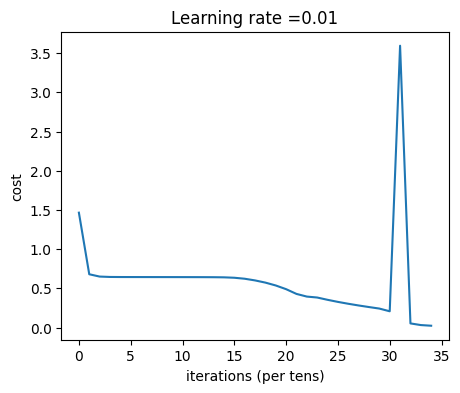

In [204]:
### CONSTANTS ###
#num_iterations=3500
#learning_rate=0.01
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims = [12288, 20, 7, 5, 1], activation='softplus', num_iterations = 3500, learning_rate=0.01, print_cost = True)

In [205]:
predictions_train = predict(train_x, train_y, parameters, activation= 'softplus')  
predictions_test = predict(test_x, test_y, parameters, activation = 'softplus')

Accuracy: 0.9952153110047844
Accuracy: 0.7


### Task 12: which model/setting performs the best? what did you learn by working on this lab

The best performing model was our original model, reaching a 0.093 cost that resulted in a 98% train and 80% test accuracy.

The softplus model performed very similarly to the original model, which makes sense considering that softplus is simply a smooth approximation of ReLu. Specifically, it performed better with a 99.5% train accuracy, but worse with a 70% test accuracy.

The other two models, the adjusted initialization and sigmoid model resulted in much worse results, largely due to either too slow of a convergence/cost reduction or it being the wrong activation function for this data.

Overall, I learned that adjusting the activation function, initialization, and other hyperparameters can greatly affect the model's performance.